# Identifying and Categorizing the Disaster Related Tweets
Semantic, temporal and spatial context , using natural language processing ,Deep Learning and spatial analysis


## 1. Import Required Packages

In [1]:
import os
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
%%capture
%matplotlib inline
from sklearn.base import TransformerMixin ,BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential ,model_from_json
from tensorflow.keras.layers import Embedding,Dense,Dropout ,GlobalMaxPool1D
from IPython.display import clear_output
from google.colab import files
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [3]:
if not os.path.isfile('combined.csv'):
   dataset=files.upload()

Saving combined.csv to combined.csv


## 2. Data Loading



In [4]:

class DatasetExtractor(BaseEstimator,TransformerMixin):
    """Extractor class that loads multiple Tweeter files in csv format."""
    
    COMBINDED_DATASET='combined.csv'
    
    def transform(self,X,y=None):
        return self.hot_load()
    
    def hot_load(self):
        """Loads the pre-combined file if exists otherwise load all the files"""
        combined_file_path='combined.csv'
        if os.path.isfile(combined_file_path):
            print('File Exists.Reloaded.')
            return pd.read_csv(combined_file_path, index_col=0)
        print('Loading Files..')
        combined_dataset=load_data()
        combined_dataset.to_csv(combined_file_path)
        return combined_dataset
    
    def load_data(self):
        """Loads multiple disaster related tweet file and returns a Single Pandas data frame"""    
        combined_dataset=pd.DataFrame()
        for file_name in os.listdir(path=DATA_DIRECTORY):
            category=extract_category_name(file_name)
            df=pd.read_csv(f'{file_name}')
            df['category']= category    
            combined_dataset=combined_dataset.append(df,ignore_index = True)
        return  combined_dataset  
    
    def extract_category_name(self,file_name):
        """Helper method that extracts the Disaster Category from the file name"""
        category=file_name.split('.')[0]
        if '_' in category:
            category=category.split('_')[0]
        return category 

## 3. Data Cleaning

In [5]:
class DatasetCleaner(BaseEstimator,TransformerMixin):
    """Removes Redundent features and rows with missing values"""
    def transform(self,X,y=None):
        columns=X.columns.tolist()
        X.columns=[column.strip() for column in columns]
        X=X.drop('tweet id',axis=1)
        X=X.dropna()
        X['tweet']=X['tweet'].str.replace('@', '')
        X['tweet']=X['tweet'].str.replace('#', '')
        X['tweet']=X['tweet'].str.replace('http\S+', '',regex=True)
        X['tweet']=X['tweet'].str.strip()
        X['tweet']=X['tweet'].str.lower()        
        return X

In [6]:
class DistributionValidSampler(BaseEstimator,TransformerMixin):
    """Samples the (related and random ) tweets with equal proportion"""
    def __init__(self,unrelated_size=None ,ignore_unrelated_proportion=True):
        self._unrelated_size=unrelated_size
        self._ignore_unrelated_proportion=ignore_unrelated_proportion

        
    def transform(self,X,y=None):
        #Shuffle tweets
        X_=X.sample(frac=1).reset_index(drop=True)
        
        X_=self._label_categories(X_)  
        related,unrelated =self._equal_split(X_)
        X_=self._merge(related,unrelated)
        X_=X_.drop('category',axis=1)       
        return X_
    
    def _label_categories(self,X):
        """Assings the category name to on-topic tweets and unrelated to off-topic tweets in 
         each category
        """
        
        if self._ignore_unrelated_proportion:
            X['label']=X.apply(lambda row: row['category'] if 'on-topic' in row['label'] else 'unrelated',axis=1 ) 
        else:
            X['label']=X.apply(lambda row: row['category'] if 'on-topic' in row['label'] else 'unrelated_'+row['category'],axis=1 )  
        return X
    
    def _equal_split(self,X):
        """Splits the dataseta into related and unrelated tweets.
          This ensures that the number of unrelated tweets are not too high and 
          is in reasonable range.
        """
        related=X[X['label'].str.contains('unrelated')==False]
        unrelated=X[X['label'].str.contains('unrelated')]
        ave_tweets=self._average_tweet_per_category(X)
        unrelated=self._slice(unrelated,size=self._unrelated_size ,ave_size=ave_tweets)
        return related,unrelated
    
    def _merge(self,X1,X2):
        """Merges the dataframes toghether"""
        X=pd.DataFrame()
        X=X.append(X1)
        X=X.append(X2)
        return X
    
    def _slice(self,X, size ,ave_size):
        """Extracts a subset of rows from a dataframe"""
        if size is None:
            size =ave_size
        if size < X.shape[0]:
            return X[:size]
        return X    
    
    def _average_tweet_per_category(self,X):
        """Calculate the average number of tweets across all tweet categories"""
        category_values=pd.DataFrame(X['label'].value_counts())
        category_values=category_values.drop('unrelated',axis=0)
        return int(category_values['label'].mean())
        

### 4. Data Transformation

In [7]:
class TextTokenizer(BaseEstimator,TransformerMixin):
    
    def __init__(self,pad_sequences,num_words=10000,max_length=100,max_pad_length=100 ):
        self._num_words=num_words
        self.max_length=max_length
        self._tokenizer=None
        self._pad_sequences=pad_sequences
        self._max_pad_length=max_pad_length
        self.vocab_size=None
        self.tokenizer=None
        
    def transform(self,X,y=None):
        self.tokenizer,self.vocab_size=self._get_tokenizer(X['tweet'])
        X['tweet_encoded']=self.tokenizer.texts_to_sequences(X['tweet'])
        X['tweet_encoded']= X['tweet_encoded'].apply(lambda x: self._pad_sequences([x],maxlen=self._max_pad_length ,padding='post')[0])
        
        return X
    def _get_tokenizer(self,X):
        tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=self._num_words)
        tokenizer.fit_on_texts(X)
        vocab_size=len(tokenizer.word_index)+1
        return tokenizer,vocab_size

In [8]:
class LabelOneHotEncoder(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.label_encoder=None
        self.one_hot_encoder=None
        
    def transform(self,X,y=None):
        self.label_encoder=LabelEncoder().fit(X['label'])
        self.one_hot_encoder=to_categorical
        num_classes=len(set(X['label']))
        X['label_encoded']= self.label_encoder.transform(X['label'].values)
        X['label_one_hot']= X['label_encoded'].apply(lambda x: self.one_hot_encoder([x],num_classes=num_classes)[0])   
        
        return X
      

In [9]:
class PassThroughTransformer(BaseEstimator,TransformerMixin):
    """Pass Through Trasformer to by pass the sklean pipleline limitation """
    def transform(self,X,y=None):
        return X
    def fit(self,X,y=None):
        return X

In [10]:
pad_sequence=tf.keras.preprocessing.sequence.pad_sequences


pipeline =Pipeline(steps=[
    ('extractor',DatasetExtractor()),
    ('cleaner',DatasetCleaner()),
    ('distribution-validator',DistributionValidSampler(unrelated_size=None ,ignore_unrelated_proportion=True)),
    ('tokenizer',TextTokenizer(pad_sequence)),
    ('one-hot-encoder',LabelOneHotEncoder()),
    ('pass-through',PassThroughTransformer()),
    
])
cleaned=pipeline.transform(None)
cleaned.head()

File Exists.Reloaded.


,tweet,label,tweet_encoded,label_encoded,label_one_hot
1,rt anjurestaurant: please spread the word. all...,floods,"[2, 6039, 70, 830, 1, 616, 27, 9, 821, 7, 234,...",3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
3,"baby stuffed in bag, hoisted from flood: austr...",floods,"[256, 349, 3, 310, 351, 22, 9, 251, 221, 259, ...",3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
4,our thoughts and prayers are with all those af...,tornado,"[59, 87, 7, 51, 21, 25, 27, 69, 65, 28, 1, 539...",5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
5,good time to run the country like a business m...,hurricane,"[153, 124, 4, 477, 1, 428, 71, 6, 842, 544, 40...",4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
6,stuck in hurricane sandy!! flight back from ny...,hurricane,"[1149, 3, 12, 23, 1637, 213, 22, 461, 3912, 0,...",4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"


## 5. Train Validation set

In [11]:
X_train,X_test,y_train,y_test =train_test_split(cleaned['tweet_encoded'],cleaned['label_one_hot'],test_size=0.3,stratify=cleaned['label_encoded'])
X_train=np.array(X_train.values.tolist())
X_test=np.array(X_test.values.tolist())
y_train=np.array(y_train.values.tolist())
y_test=np.array(y_test.values.tolist())

## 6. Modeling 

In [12]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
plot_losses = PlotLosses() 

def save_model(model,save_name):
    with open(save_name,'w+') as f:
        f.write(model.to_json())
    model.save_weights(save_name+'.h5') 

In [13]:
tokenizer=pipeline.named_steps['tokenizer']
max_length=tokenizer.max_length
vocab_size=tokenizer.vocab_size
embeding_dim=50
num_classes=y_train[0].shape[0]
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embeding_dim,input_length=max_length))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(10,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'] )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           2291700   
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 77        
Total params: 2,292,287
Trainable params: 2,292,287
Non-trainable params: 0
______________________________________________

## 7. Training 

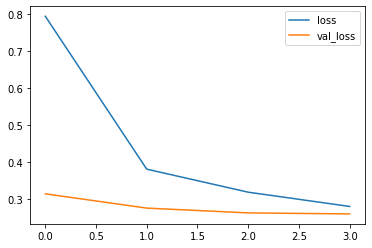

In [14]:
model.fit(X_train,y_train,epochs=4,batch_size=10,verbose=0,validation_split=0.2,callbacks=[plot_losses])
save_model(model,'model')

## 8. Evaluation

In [15]:
# load json and create model
json_file = open('model', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 92.09%


## 9. Prediction

In [16]:
vocab_size=pipeline.named_steps['tokenizer'].vocab_size
max_length=pipeline.named_steps['tokenizer'].max_length
label_encoder=pipeline.named_steps['one-hot-encoder'].label_encoder
tokenizer=pipeline.named_steps['tokenizer'].tokenizer
max_length=pipeline.named_steps['tokenizer'].max_length


x=['large explosion at a texas fertilizer plant...multiple injuries reported...local hospital told to expect up to 100 patients: via ap']

x_seq=tokenizer.texts_to_sequences(x)[0]
x_pad=tf.keras.preprocessing.sequence.pad_sequences([x_seq],maxlen=max_length ,padding='post')[0]
x_pad=np.array(x_pad)
x_pad=x_pad.reshape(1,100)
x_pad.shape
predict=loaded_model.predict_classes(x_pad)
score=max(loaded_model.predict(x_pad)[0])
print(predict)
print(label_encoder.inverse_transform(predict))
print('score',score)

[2]
['explosion']
score 0.9999862


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## 10. Hyperparameters Optimization

In [17]:
def create_model(dropout, dense_size, vocab_size, embedding_dim, maxlen):
    model=Sequential()
    model.add(Embedding(input_dim=vocab_size,output_dim=embeding_dim,input_length=max_length))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(dropout))
    model.add(Dense(dense_size,activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [18]:
  
# Main settings
epochs = 5
embedding_dim = 50
maxlen = 100
vocab_size=10000
output_file = 'output.txt'
#  dropout=[.1, 0.2, 0.3,0.4,0.5],
dense_size=[10, 50,100],

# Parameter grid for grid search
param_grid = dict(dropout=[0.1],
                  dense_size=[10, 50,100],
                  vocab_size=[vocab_size],
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])
model = KerasClassifier(build_fn=create_model,
                        epochs=epochs, batch_size=10,
                        verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=5 ,n_jobs=2)
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)

# Save and evaluate results
with open(output_file, 'a') as f:
    s = ('Best Accuracy : '
         '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
    print(output_string)
    f.write(output_string)  
print('Done')    

Fitting 4 folds for each of 3 candidates, totalling 12 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed: 12.1min finished


Best Accuracy : 0.9234
{'vocab_size': 10000, 'maxlen': 100, 'embedding_dim': 50, 'dropout': 0.1, 'dense_size': 10}
Test Accuracy : 0.9243


Done
